In [1]:

from sectional_v2.util.eusaar_data import *
import sectional_v2.util.eusaar_data as lfc
import sectional_v2.util.eusaar_data
from sectional_v2.constants import get_plotpath

/home/ubuntu/mnts/nird/projects//Output_data_SECTIONAL_SCHEME/
/home/ubuntu/mnts/nird/projects/SECTIONAL_v2/sectional_v2/data_info/area_defs.csv


In [2]:
# load and autoreload
from IPython import get_ipython

# noinspection PyBroadException
try:
    _ipython = get_ipython()
    _magic = _ipython.magic
    _magic('load_ext autoreload')
    _magic('autoreload 2')
except:
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from sectional_v2.constants import get_outdata_path
path_in = get_outdata_path('eusaar')
version ='_noresmv21_dd'
file_in = path_in + 'Nd_cat_sources_timeseries%s.csv'%version
plot_path = get_plotpath('eusaar')

version ='_noresmv21dd_both'

figname = f'{plot_path}/NRMSE{version}.'

In [4]:
# case_ns = 'noSECTv11_ctrl_fbvoc'
# case_sec = 'SECTv11_ctrl_fbvoc'
case_sec='SECTv21_ctrl_koagD' #'SECTv11_ctrl_fbvoc']#'SECTv11_ctrl']#,'SECTv11_ctrl_fbvoc']#'SECTv11_ctrl']
case_ns ='noSECTv21_ox_ricc' #'noSECTv11_ctrl_fbvoc'] #/no SECTv11_ctrl
cases_ns = ['noSECTv21_default_dd','noSECTv21_ox_ricc_dd']
cases_s = [case_sec]
cases = cases_ns + cases_s
eusaar='eusaar'

## Plotting functions:

In [5]:
trns ={
    'N30-50':'N$_{30-50}$',
    'N30-100':'N$_{30-100}$',   
    'N50-100':'N$_{50-100}$',
    'N50':'N$_{50-500}$',
    'N100':'N$_{100-500}$',   
    'N250':'N$_{250-500}$'   
    }

In [6]:
from sectional_v2.data_info import get_nice_name_case

In [7]:
df = pd.read_csv(file_in, index_col=0)

/persistent01/miniconda3/envs/env_sec_v2/lib/python3.6/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
df_gd = df[df['flag_gd']]

In [9]:
df_gd = df_gd.rename(trns, axis=1)

In [10]:
c_N = ['N30-50', 'N50', 'N100', 'N250', 'N50-100', 'N30-100']
c_N = [trns[key] for key in trns.keys()]

In [11]:
df_dic = {}
for case in cases :
    _df=sectional_v2.util.eusaar_data.clean_df(df_gd,sc=case).reset_index()
    _df['time'] = pd.to_datetime(_df['time'])
    df_dic[case] = _df.set_index('time')
_df=sectional_v2.util.eusaar_data.clean_df(df_gd,sc=eusaar).reset_index()
_df['time'] = pd.to_datetime(_df['time'])
df_eusaar =_df.set_index('time')



In [12]:
def nrmse_calc(df_m, df_eu):
    #if 'station' in df_model.columns:
    #    df_model = df_model.drop('station', axis=1)#\
    #if 'station' in df_eusaar.columns:
    #    df_eusaar = df_eusaar.drop('station', axis=1)#\
    df_model = df_m[c_N]
    df_eusaar = df_eu[c_N]
    rmse = ((df_model - df_eusaar) ** 2).mean() ** .5
    # normalize by mean:
    rmse = rmse/df_eusaar.mean()
    rmse = rmse._set_name(case)
    return rmse
def get_nrmse_all(df_dic, df_eusaar):
    rmse_dic = {}
    for case in cases:
        df_model = df_dic[case]
        _rmse=nrmse_calc(df_model, df_eusaar)
        _rmse = _rmse._set_name(case)
        rmse_dic[case] = _rmse
    rmse_all = pd.concat([rmse_dic[case] for case in cases], axis=1)
    return rmse_dic, rmse_all
rmse_dic, rmse_all = get_nrmse_all(df_dic, df_eusaar)



In [13]:
def add_season(df_dic):
    df_seas ={}
    for case in cases:
        _df_all = df_dic[case]
        _df_all = add_seas(_df_all)
        df_seas[case] = _df_all

    return df_seas


def add_seas(_df_all):
    _df_all['season'] = _df_all.to_xarray()['time.season'].to_series()  # df_dic[case].reset_index().dt.season
    return  _df_all

def get_season(dic_df_seas, seas):
    dic_df_s ={}
    for case in dic_df_seas.keys():
        dic_df_s[case] = dic_df_seas[case][dic_df_seas[case]['season'] == seas]
    return dic_df_s
def get_station(dic_df_seas, station):
    dic_df_s ={}
    for case in dic_df_seas.keys():
        dic_df_s[case] = dic_df_seas[case][dic_df_seas[case]['station'] == station]
    return dic_df_s

In [14]:
def rmse_seas(df_dic, df_eusaar):
    df_dic_s = add_season(df_dic)
    df_eusaar_seas = add_seas(df_eusaar)
    ls_rmse =[]# pd.DataFrame()
    for seas in df_dic[case]['season'].unique():
        _dic_s = get_season(df_dic_s, seas)
        _df_eu_s = df_eusaar_seas[df_eusaar_seas['season'] == seas]

        rmse_dic, rmse_all = get_nrmse_all(_dic_s, _df_eu_s)
        rmse_all['season'] = seas
        rmse_all.index=rmse_all.index.rename('var')
        rmse_all = rmse_all.reset_index().set_index(['var','season'])
        ls_rmse.append(rmse_all)
    return pd.concat(ls_rmse)

def rmse_seas_station(df_dic, df_eusaar):
    df_dic_s = add_season(df_dic)
    df_eusaar_seas = add_seas(df_eusaar)

    ls_rmse =[]# pd.DataFrame()

    for seas in df_dic[case]['season'].unique():
        _df_eu_s = df_eusaar_seas[df_eusaar_seas['season'] == seas]
        _dic_s = get_season(df_dic_s, seas)

        for station in df_eusaar_seas['station'].unique():
            _dic_ss = get_station(_dic_s, station)
            _df_eu_ss = _df_eu_s[_df_eu_s['station'] == station]
            
            rmse_dic, rmse_all = get_nrmse_all(_dic_ss, _df_eu_ss)
            rmse_all['season'] = seas
            rmse_all['station'] = station
            rmse_all.index=rmse_all.index.rename('var')
            rmse_all = rmse_all.reset_index().set_index(['var','season','station'])
            ls_rmse.append(rmse_all)
    pd.concat(ls_rmse)
    return pd.concat(ls_rmse)

def rmse_station(df_dic, df_eusaar):
    #df_dic_s =  add_season(df_dic)
    #df_eusaar_seas = add_seas(df_eusaar)

    ls_rmse =[]# pd.DataFrame()


    for station in df_eusaar['station'].unique():
        _dic_ss = get_station(df_dic, station)
        _df_eu_ss = df_eusaar[df_eusaar['station'] == station]

        rmse_dic, rmse_all = get_nrmse_all(_dic_ss, _df_eu_ss)
        #rmse_all['season'] = seas
        rmse_all['station'] = station
        rmse_all.index=rmse_all.index.rename('var')
        rmse_all = rmse_all.reset_index().set_index(['var','station'])
        ls_rmse.append(rmse_all)
    pd.concat(ls_rmse)
    return pd.concat(ls_rmse)

In [15]:
df_dic_dailym = {}
for case in df_dic.keys():
    _df = df_dic[case]
    _df = _df.reset_index().set_index(['time','station'])
    _df= _df.groupby([pd.Grouper(level='station'),
             pd.Grouper(level='time', freq='1D')]).mean()
    df_dic_dailym[case] = _df.reset_index().set_index('time')

In [16]:
_df = df_eusaar
_df = _df.reset_index().set_index(['time','station'])
#_df.resample('D', level=-1).mean()
df_eusaar_dailym = _df.groupby([pd.Grouper(level='station'),
            pd.Grouper(level='time', freq='1D')]).mean()
df_eusaar_dailym = df_eusaar_dailym.reset_index().set_index('time')

In [17]:
rms_st_day = rmse_station(df_dic_dailym, df_eusaar_dailym)

In [18]:
rms_st = rmse_station(df_dic, df_eusaar)

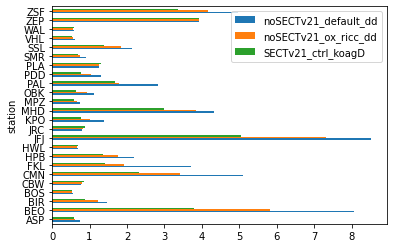

In [19]:

rms_st_day.unstack().stack().loc[('N$_{50-100}$')].plot.barh()
plt.show()

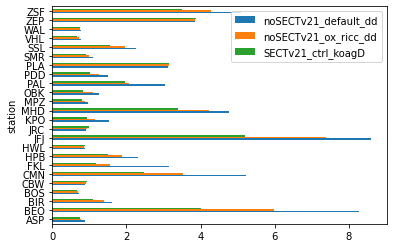

In [20]:
rms_st
rms_st.unstack().stack().loc[('N$_{50-100}$')].plot.barh()
plt.show()

In [21]:
rms_seas = rmse_seas(df_dic, df_eusaar)

In [22]:
rms_seas_st = rmse_seas_station(df_dic, df_eusaar)

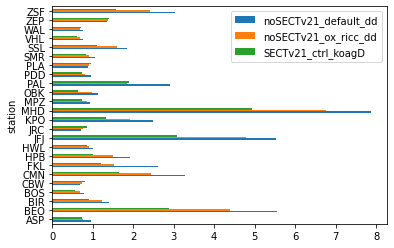

In [23]:
rms_seas_st.unstack().stack().loc[('N$_{50-100}$','JJA')].plot.barh()
plt.show()

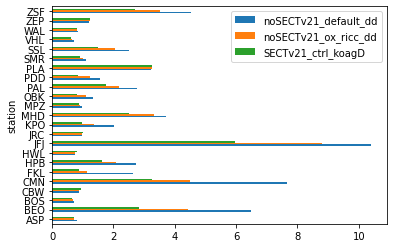

In [24]:
rms_seas_st.unstack().stack().loc[('N$_{50-100}$','MAM')].plot.barh()
plt.show()

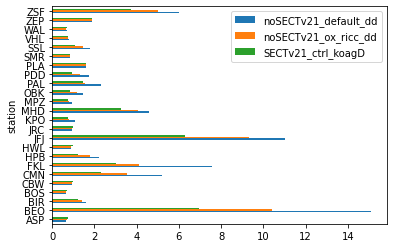

In [25]:
rms_seas_st.unstack().stack().loc[('N$_{50-100}$','SON')].plot.barh()
plt.show()

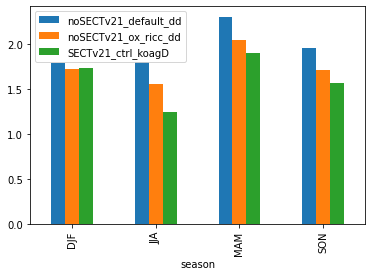

In [26]:
rms_seas.unstack().stack().loc['N$_{50-100}$'].plot.bar()
plt.show()

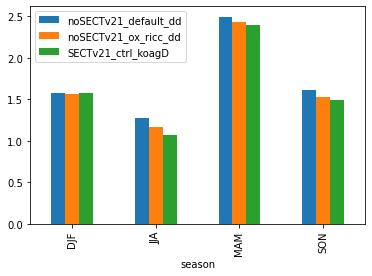

In [27]:
rms_seas.unstack().stack().loc['N$_{50-500}$'].plot.bar()
plt.show()

In [28]:
plt_df = rms_seas.unstack().stack()[cases[::-1]]

In [29]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements=[]
for case in cases_ns+[case_sec]:
    print(case)
    c=get_case_col(case)
    legend_elements.append(Patch(facecolor=c, edgecolor=c, label=get_nice_name_case(case)))

noSECTv21_default_dd
noSECTv21_ox_ricc_dd
SECTv21_ctrl_koagD


/home/ubuntu/mnts/nird/projects//Plots_SECTIONAL_SCHEME/eusaar//NRMSE_noresmv21dd_both.


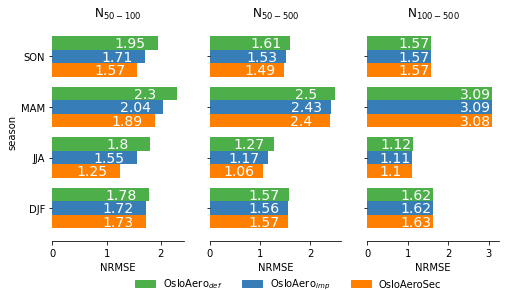

In [30]:
var = 'N$_{50-100}$'
cdic = {case:get_case_col(case) for case in cases}
fig, axs = plt.subplots(1,3, figsize=[8,4], sharey=True)
def _plt_bar(var, ax):
    color=[cdic.get(x, '#333333') for x in plt_df.columns]
    ax =plt_df.loc[var].plot.barh(color=color , width=0.8, ax=ax, legend=False)
    for i in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(i.get_width()-0.8, i.get_y()+.04, \
            str(round((i.get_width()), 2)), fontsize=14, color='w')
    ax.set_title(var)
    return ax
for var, ax in zip(['N$_{50-100}$','N$_{50-500}$','N$_{100-500}$'], axs.flatten()):
    _plt_bar(var, ax)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([], minor=True)
 
    ax.set_xlabel('NRMSE')

lgd=fig.legend(handles=legend_elements, frameon=False,bbox_to_anchor=(0.0, -.02, 1., -.02), loc='lower center',
           ncol=3,  borderaxespad=0.)#mode="expand",)
plt.subplots_adjust()
plt.savefig(figname + 'pdf', dpi=300,  bbox_extra_artists=(lgd,), bbox_inches='tight')
print(figname)
plt.show()